# Part 2: Trip Duration Prediction Model

This notebook builds a linear regression model to predict Citi Bike trip duration based on weather conditions and time features.

In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Merged Data & Prepare Target

Load the merged trips and weather data from the datacleaning step, then create duration features and time-based variables.

In [87]:
# 1. Load CSV from datacleaning
print("="*60)
print("LOADING MERGED DATA")
print("="*60)

df = pd.read_csv("modeling_dataset.csv", parse_dates=["starttime"])

print(f"\n✓ Merged dataset loaded successfully!")
print(f"  Initial shape: {df.shape}")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")

# 2. Create duration and basic filters
print("\n" + "="*60)
print("CREATING DURATION & APPLYING FILTERS")
print("="*60)

df["trip_duration_min"] = df["tripduration"] / 60
print(f"\nBefore filtering: {len(df):,} rows")

df = df[(df["trip_duration_min"] >= 1) & (df["trip_duration_min"] <= 120)]
print(f"After filtering (1-120 min): {len(df):,} rows")

# 3. Create log target
df["log_duration"] = np.log(df["trip_duration_min"])
print(f"\n✓ Created log_duration target variable")

# 4. Time features
print("\n" + "="*60)
print("CREATING TIME FEATURES")
print("="*60)

df["weekday"] = df["starttime"].dt.weekday   # 0=Mon
df["is_weekend"] = (df["weekday"] >= 5).astype(int)

# Create hour if not already present
if "hour" not in df.columns:
    df["hour"] = df["starttime"].dt.hour

print(f"\n✓ Time features created:")
print(f"  - weekday (0=Mon, 6=Sun)")
print(f"  - is_weekend (0=weekday, 1=weekend)")
print(f"  - hour (0-23)")

print(f"\nFinal dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df[["starttime", "trip_duration_min", "log_duration", "hour", "weekday", "is_weekend"]].head(3))
print("="*60)

LOADING MERGED DATA

✓ Merged dataset loaded successfully!
  Initial shape: (18799954, 38)
  Rows: 18,799,954
  Columns: 38

CREATING DURATION & APPLYING FILTERS

Before filtering: 18,799,954 rows
After filtering (1-120 min): 18,799,954 rows

✓ Created log_duration target variable

CREATING TIME FEATURES

✓ Time features created:
  - weekday (0=Mon, 6=Sun)
  - is_weekend (0=weekday, 1=weekend)
  - hour (0-23)

Final dataset shape: (18799954, 38)

First few rows:
                starttime  trip_duration_min  log_duration  hour  weekday  \
0 2018-09-01 00:00:05.269          27.250000      3.305054     0        5   
1 2018-09-01 00:00:11.281           2.200000      0.788457     0        5   
2 2018-09-01 00:00:20.649          55.616667      4.018483     0        5   

   is_weekend  
0           1  
1           1  
2           1  


## Quick Descriptive Tables & Plots

Explore how weather conditions affect trip duration through summary statistics and visualizations.

In [88]:
# Summary by temperature bin
print("="*60)
print("TRIP DURATION BY TEMPERATURE BIN")
print("="*60)
print()

temp_summary = df.groupby("temp_bin")["trip_duration_min"].agg(["count", "mean", "median"])
print(temp_summary)
print()
print("="*60)

TRIP DURATION BY TEMPERATURE BIN

            count       mean     median
temp_bin                               
0–10°C    5111718  12.054928   9.033333
10–20°C   5256055  13.705909  10.300000
20–30°C   6905244  14.392969  10.900000
<0°C       882865  11.089231   8.433333
>30°C      644072  14.181058  10.850000



In [89]:
# Summary by rain
print("="*60)
print("TRIP DURATION BY RAIN FLAG")
print("="*60)
print()

rain_summary_stats = df.groupby("rain_flag")["trip_duration_min"].agg(["count", "mean", "median"])
print(rain_summary_stats)
print()
print("Interpretation:")
print(f"  • No rain (0): Average {rain_summary_stats.loc[0, 'mean']:.2f} minutes")
print(f"  • Rain (1): Average {rain_summary_stats.loc[1, 'mean']:.2f} minutes")
if rain_summary_stats.loc[0, 'mean'] > rain_summary_stats.loc[1, 'mean']:
    diff = rain_summary_stats.loc[0, 'mean'] - rain_summary_stats.loc[1, 'mean']
    pct = (diff / rain_summary_stats.loc[0, 'mean']) * 100
    print(f"  • Rain reduces trip duration by {diff:.2f} minutes ({pct:.1f}%)")
print("="*60)

TRIP DURATION BY RAIN FLAG

              count       mean     median
rain_flag                                
0          16081967  13.504532  10.116667
1           2717987  12.800593   9.583333

Interpretation:
  • No rain (0): Average 13.50 minutes
  • Rain (1): Average 12.80 minutes
  • Rain reduces trip duration by 0.70 minutes (5.2%)


<Figure size 1000x600 with 0 Axes>

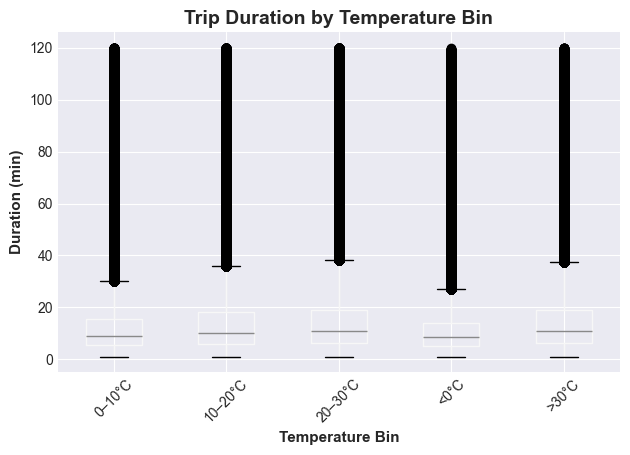

📊 The boxplot shows the distribution of trip durations across temperature ranges.


In [90]:
# Boxplot: duration vs temp_bin
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
df.boxplot(column="trip_duration_min", by="temp_bin", rot=45)
plt.suptitle("")
plt.title("Trip Duration by Temperature Bin", fontsize=14, fontweight='bold')
plt.ylabel("Duration (min)", fontsize=11, fontweight='bold')
plt.xlabel("Temperature Bin", fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

print("📊 The boxplot shows the distribution of trip durations across temperature ranges.")

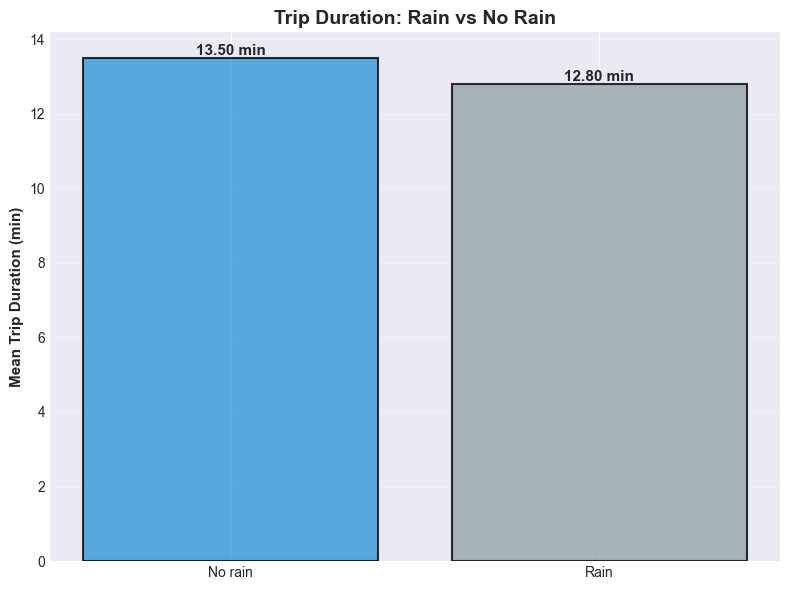

📊 The bar chart compares average trip duration between rainy and non-rainy conditions.


In [91]:
# Bar chart: rain vs no rain
rain_summary = df.groupby("rain_flag")["trip_duration_min"].mean().reset_index()
rain_summary["rain_label"] = rain_summary["rain_flag"].map({0: "No rain", 1: "Rain"})

plt.figure(figsize=(8, 6))
bars = plt.bar(rain_summary["rain_label"], rain_summary["trip_duration_min"], 
               color=['#3498db', '#95a5a6'], alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f} min',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel("Mean Trip Duration (min)", fontsize=11, fontweight='bold')
plt.title("Trip Duration: Rain vs No Rain", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("📊 The bar chart compares average trip duration between rainy and non-rainy conditions.")

## PCA on Weather Features

Apply Principal Component Analysis (PCA) to reduce the dimensionality of weather features and visualize weather patterns.

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print("="*60)
print("PCA ON WEATHER FEATURES")
print("="*60)

# Select weather features and drop missing values
weather_feats = df[["temperature_2m_(°c)", "precip_mm", "wind_kmh"]].dropna()

print(f"\nWeather features selected:")
print(f"  - temperature_2m_(°c)")
print(f"  - precip_mm")
print(f"  - wind_kmh")
print(f"\nSamples after dropping NaN: {len(weather_feats):,}")

# Standardize features
scaler = StandardScaler()
scaled = scaler.fit_transform(weather_feats)

print(f"\n✓ Features standardized (mean=0, std=1)")

# Apply PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(scaled)

# Add principal components back to dataframe
df.loc[weather_feats.index, "pc1"] = pcs[:, 0]
df.loc[weather_feats.index, "pc2"] = pcs[:, 1]

print(f"\n✓ PCA completed with 2 components")
print(f"\nExplained variance ratio:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]*100:.2f}%)")
print(f"  Total: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")

print(f"\nPCA components (loadings):")
components_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=['temperature_2m_(°c)', 'precip_mm', 'wind_kmh']
)
print(components_df)
print("="*60)

PCA ON WEATHER FEATURES

Weather features selected:
  - temperature_2m_(°c)
  - precip_mm
  - wind_kmh

Samples after dropping NaN: 18,799,954

✓ Features standardized (mean=0, std=1)

✓ PCA completed with 2 components

Explained variance ratio:
  PC1: 0.3989 (39.89%)
  PC2: 0.3480 (34.80%)
  Total: 0.7468 (74.68%)

PCA components (loadings):
                          PC1       PC2
temperature_2m_(°c) -0.631107  0.483197
precip_mm            0.247636  0.866854
wind_kmh             0.735105  0.122819


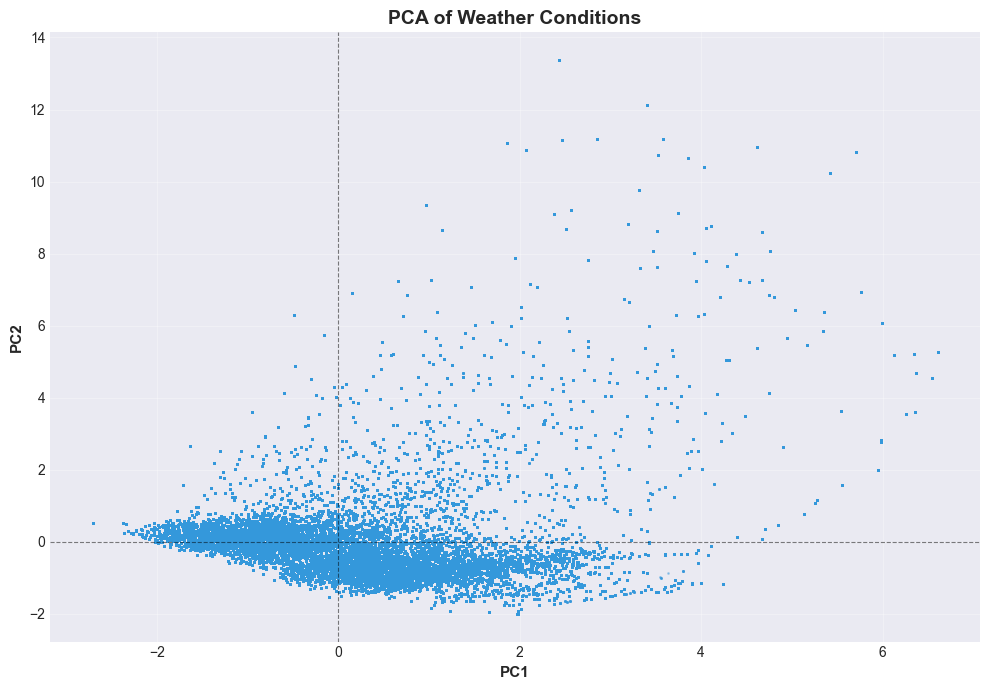


📊 The scatter plot shows how weather conditions are distributed in the
   reduced 2D space. Each point represents a trip with its weather conditions.

   PC1 and PC2 capture 74.7% of the variance in weather features.


In [93]:
# Plot PCA results
plt.figure(figsize=(10, 7))
plt.scatter(df["pc1"], df["pc2"], alpha=0.2, s=1, c='#3498db')
plt.xlabel("PC1", fontsize=11, fontweight='bold')
plt.ylabel("PC2", fontsize=11, fontweight='bold')
plt.title("PCA of Weather Conditions", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.tight_layout()
plt.show()

print("\n📊 The scatter plot shows how weather conditions are distributed in the")
print("   reduced 2D space. Each point represents a trip with its weather conditions.")
print(f"\n   PC1 and PC2 capture {pca.explained_variance_ratio_.sum()*100:.1f}% of the variance in weather features.")

## Regression Model

Build the feature matrix X and target variable y, then train a linear regression model.

In [94]:
# Build X and y
print("="*60)
print("BUILDING FEATURE MATRIX X AND TARGET y")
print("="*60)

features = [
    "temperature_2m_(°c)",
    "rain_flag",
    "wind_kmh",
    "hour",
    "weekday",
    "is_weekend",
]

print(f"\nSelected features:")
for i, feat in enumerate(features, 1):
    print(f"  {i}. {feat}")

X = df[features].copy()
X = pd.get_dummies(X, columns=["hour", "weekday"], drop_first=True)

y = df["log_duration"]

print(f"\nFinal X shape: {X.shape}")
print(f"  Rows: {X.shape[0]:,}")
print(f"  Features: {X.shape[1]}")
print(f"\nTarget y shape: {y.shape}")
print("="*60)

BUILDING FEATURE MATRIX X AND TARGET y

Selected features:
  1. temperature_2m_(°c)
  2. rain_flag
  3. wind_kmh
  4. hour
  5. weekday
  6. is_weekend

Final X shape: (18799954, 33)
  Rows: 18,799,954
  Features: 33

Target y shape: (18799954,)


In [95]:
# Train/test split + fit linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

print("\n" + "="*60)
print("TRAIN/TEST SPLIT + MODEL TRAINING")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

model = LinearRegression()
model.fit(X_train, y_train)

print(f"\n✓ Model trained successfully!")
print(f"  Intercept: {model.intercept_:.4f}")

# Predictions and evaluation
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Performance:")
print(f"  R²: {r2:.4f}")
print(f"  RMSE: {rmse:.4f}")

print(f"\nInterpretation:")
print(f"  • R² of {r2:.4f} means the model explains {r2*100:.2f}% of variance")
print(f"  • RMSE of {rmse:.4f} in log scale")
print("="*60)


TRAIN/TEST SPLIT + MODEL TRAINING

Train set: 15,039,963 samples
Test set: 3,759,991 samples

✓ Model trained successfully!
  Intercept: 2.0724

Model Performance:
  R²: 0.0234
  RMSE: 0.7555

Interpretation:
  • R² of 0.0234 means the model explains 2.34% of variance
  • RMSE of 0.7555 in log scale


In [96]:
# Coefficient table (for later interpretation)
print("\n" + "="*60)
print("COEFFICIENT TABLE")
print("="*60)

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": model.coef_
}).sort_values("coef", ascending=False)

print("\nAll coefficients (sorted by magnitude):")
print(f"Total features: {len(coef_df)}")

print("\nTop 10 positive coefficients:")
print(coef_df.head(10).to_string(index=False))

print("\nTop 10 negative coefficients:")
print(coef_df.tail(10).to_string(index=False))

print("\n" + "="*60)
print("WEATHER FEATURE COEFFICIENTS")
print("="*60)

weather_coefs = coef_df[coef_df["feature"].str.contains("temperature_2m|rain_flag|wind_kmh")]
print("\nWeather-related coefficients:")
print(weather_coefs.to_string(index=False))
print("="*60)


COEFFICIENT TABLE

All coefficients (sorted by magnitude):
Total features: 33

Top 10 positive coefficients:
feature     coef
hour_14 0.185608
hour_15 0.183637
hour_17 0.179195
hour_16 0.173493
hour_13 0.160328
hour_11 0.160262
hour_12 0.151454
hour_18 0.145169
 hour_8 0.135313
hour_10 0.116776

Top 10 negative coefficients:
  feature      coef
weekday_3 -0.003417
weekday_2 -0.004022
weekday_1 -0.011498
   hour_1 -0.034674
rain_flag -0.064089
   hour_2 -0.071511
   hour_6 -0.074063
   hour_3 -0.082452
   hour_5 -0.114455
   hour_4 -0.115742

WEATHER FEATURE COEFFICIENTS

Weather-related coefficients:
            feature      coef
temperature_2m_(°c)  0.008250
           wind_kmh -0.001732
          rain_flag -0.064089


## Visualizing Weather Feature Impacts

Let's create visual representations of how weather conditions affect trip duration.

In [97]:
# Extract weather coefficients
weather_features = ['temperature_2m_(°c)', 'wind_kmh', 'rain_flag']
weather_coefs = coef_df[coef_df['feature'].isin(weather_features)].copy()

# Create cleaner labels
weather_coefs['Feature'] = weather_coefs['feature'].map({
    'temperature_2m_(°c)': 'Temperature (°C)',
    'wind_kmh': 'Wind Speed (km/h)',
    'rain_flag': 'Rain'
})

# Calculate percentage impact (using 'coef' column)
weather_coefs['Percentage_Impact'] = ((np.exp(weather_coefs['coef']) - 1) * 100)
# For negative coefficients, calculate properly
weather_coefs.loc[weather_coefs['coef'] < 0, 'Percentage_Impact'] = -(
    (1 - np.exp(weather_coefs.loc[weather_coefs['coef'] < 0, 'coef'])) * 100
)

print("Weather coefficients prepared for visualization:")
print(weather_coefs[['Feature', 'coef', 'Percentage_Impact']])

Weather coefficients prepared for visualization:
             Feature      coef  Percentage_Impact
0   Temperature (°C)  0.008250           0.828372
2  Wind Speed (km/h) -0.001732          -0.173076
1               Rain -0.064089          -6.207886


## Regression Model Visualizations

Visualize how feature values affect the target variable and assess model performance.

In [ ]:
# 1. Predicted vs Actual plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Predicted vs Actual
sample_size = min(10000, len(y_test))  # Sample for better visualization
sample_idx = np.random.choice(len(y_test), sample_size, replace=False)
y_test_sample = y_test.iloc[sample_idx]
y_pred_sample = y_pred[sample_idx]

ax1.scatter(y_test_sample, y_pred_sample, alpha=0.3, s=1)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect prediction')
ax1.set_xlabel('Actual log(duration)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Predicted log(duration)', fontsize=11, fontweight='bold')
ax1.set_title('Predicted vs Actual Values', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residual plot
residuals = y_test_sample - y_pred_sample
ax2.scatter(y_pred_sample, residuals, alpha=0.3, s=1)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted log(duration)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Residuals', fontsize=11, fontweight='bold')
ax2.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Model Performance Summary:")
print(f"  • R² = {r2:.4f} - Model explains {r2*100:.2f}% of variance")
print(f"  • RMSE = {rmse:.4f} - Average prediction error")
print(f"  • Perfect predictions would fall on the red diagonal line")

In [ ]:
# 2. Weather Features vs Target (with trend lines)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

weather_features_plot = ['temperature_2m_(°c)', 'wind_kmh', 'rain_flag']
feature_labels = ['Temperature (°C)', 'Wind Speed (km/h)', 'Rain (0=No, 1=Yes)']

# Sample data for clearer visualization
sample_size = min(5000, len(df))
sample_df = df.sample(n=sample_size, random_state=42)

for idx, (feature, label) in enumerate(zip(weather_features_plot, feature_labels)):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(sample_df[feature], sample_df['log_duration'], 
               alpha=0.3, s=5, c='#3498db')
    
    # Add trend line using coefficient from model
    if feature in ['temperature_2m_(°c)', 'wind_kmh']:
        # Get the coefficient for this feature
        coef_value = coef_df[coef_df['feature'] == feature]['coef'].values[0]
        
        # Create trend line
        x_range = np.array([sample_df[feature].min(), sample_df[feature].max()])
        # Simple trend: y = intercept + coef * x (ignoring other features for visualization)
        y_trend = sample_df['log_duration'].mean() + coef_value * (x_range - sample_df[feature].mean())
        ax.plot(x_range, y_trend, 'r-', linewidth=2, 
                label=f'Slope: {coef_value:.4f}')
    elif feature == 'rain_flag':
        # Box plot for categorical
        no_rain = sample_df[sample_df['rain_flag'] == 0]['log_duration']
        rain = sample_df[sample_df['rain_flag'] == 1]['log_duration']
        ax.clear()
        bp = ax.boxplot([no_rain, rain], labels=['No Rain', 'Rain'], 
                        patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('#3498db')
            patch.set_alpha(0.6)
    
    ax.set_xlabel(label, fontsize=11, fontweight='bold')
    ax.set_ylabel('log(duration)', fontsize=11, fontweight='bold')
    ax.set_title(f'{label.split()[0]} Effect', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    if feature != 'rain_flag':
        ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

print("\n📈 Feature Effects Interpretation:")
print("  • Temperature: Positive slope → warmer = longer trips")
print("  • Wind: Negative slope → windier = shorter trips")
print("  • Rain: Lower median on rainy days → rain reduces duration")

In [ ]:
# 3. Feature Effect Simulation - How predictions change with feature values
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Create a "typical" observation (median values)
typical_obs = X_test.median().values.reshape(1, -1)

weather_features_sim = ['temperature_2m_(°c)', 'wind_kmh', 'rain_flag']
feature_labels_sim = ['Temperature (°C)', 'Wind Speed (km/h)', 'Rain Flag']
feature_ranges = [
    np.linspace(df['temperature_2m_(°c)'].min(), df['temperature_2m_(°c)'].max(), 50),
    np.linspace(df['wind_kmh'].min(), df['wind_kmh'].max(), 50),
    np.array([0, 1])
]

for idx, (feature, label, feature_range) in enumerate(zip(weather_features_sim, feature_labels_sim, feature_ranges)):
    ax = axes[idx]
    
    # Get feature index in X
    feature_idx = list(X.columns).index(feature)
    
    # Vary feature value and predict
    predictions = []
    for value in feature_range:
        obs_copy = typical_obs.copy()
        obs_copy[0, feature_idx] = value
        pred = model.predict(obs_copy)[0]
        predictions.append(pred)
    
    # Plot
    if feature == 'rain_flag':
        ax.bar(['No Rain (0)', 'Rain (1)'], predictions, 
               color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5)
        ax.set_ylabel('Predicted log(duration)', fontsize=11, fontweight='bold')
        
        # Add values on bars
        for i, (x, y) in enumerate(zip(['No Rain (0)', 'Rain (1)'], predictions)):
            ax.text(i, y, f'{y:.3f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax.plot(feature_range, predictions, linewidth=2.5, color='#e74c3c')
        ax.fill_between(feature_range, predictions, alpha=0.3, color='#e74c3c')
        ax.set_xlabel(label, fontsize=11, fontweight='bold')
        ax.set_ylabel('Predicted log(duration)', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    ax.set_title(f'Effect of {label}', fontsize=12, fontweight='bold')

plt.suptitle('How Predictions Change When Varying Each Weather Feature\n(holding other features at median)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n🔍 This shows the isolated effect of each weather feature:")
print("  • The prediction for a 'typical' trip changes as we vary each weather feature")
print("  • Other features are held constant at their median values")
print("  • This helps understand the marginal effect of each feature")

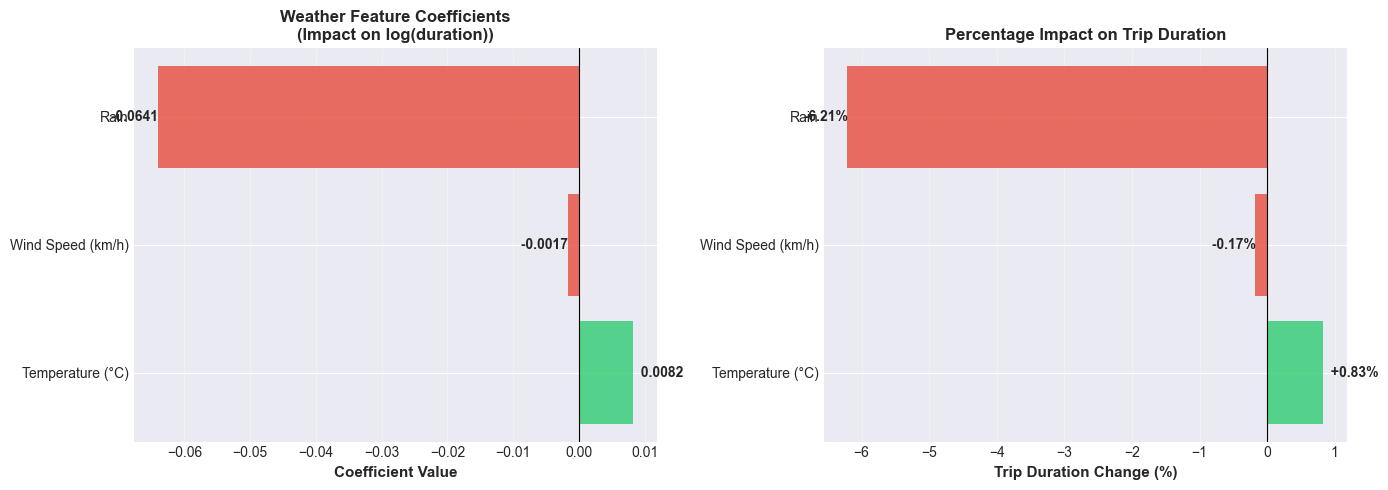

\n📊 Interpretation:
  • Green bars = increases trip duration
  • Red bars = decreases trip duration


In [98]:
# Visualization 1: Bar chart of coefficients
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Raw coefficients
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in weather_coefs['coef']]
bars1 = ax1.barh(weather_coefs['Feature'], weather_coefs['coef'], color=colors, alpha=0.8)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.set_xlabel('Coefficient Value', fontsize=11, fontweight='bold')
ax1.set_title('Weather Feature Coefficients\n(Impact on log(duration))', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(weather_coefs.iterrows()):
    value = row['coef']
    ax1.text(value, i, f'  {value:.4f}', va='center', 
             ha='left' if value > 0 else 'right', fontsize=10, fontweight='bold')

# Plot 2: Percentage impact
colors2 = ['#2ecc71' if x > 0 else '#e74c3c' for x in weather_coefs['Percentage_Impact']]
bars2 = ax2.barh(weather_coefs['Feature'], weather_coefs['Percentage_Impact'], color=colors2, alpha=0.8)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Trip Duration Change (%)', fontsize=11, fontweight='bold')
ax2.set_title('Percentage Impact on Trip Duration', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(weather_coefs.iterrows()):
    value = row['Percentage_Impact']
    ax2.text(value, i, f'  {value:+.2f}%', va='center', 
             ha='left' if value > 0 else 'right', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\\n📊 Interpretation:")
print("  • Green bars = increases trip duration")
print("  • Red bars = decreases trip duration")

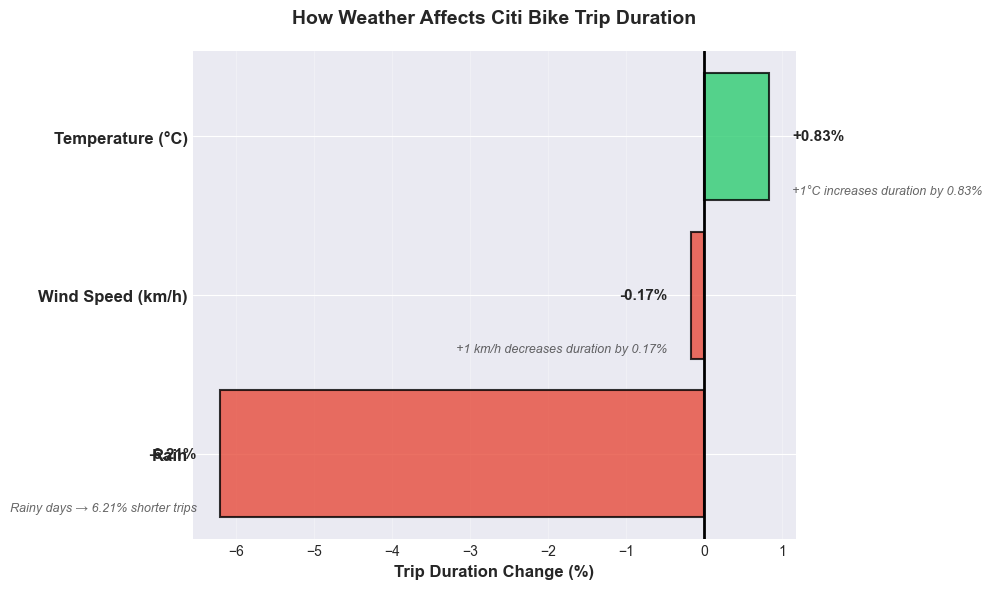

In [99]:
# Visualization 2: Comparison chart with annotations
fig, ax = plt.subplots(figsize=(10, 6))

# Sort by absolute percentage impact
weather_sorted = weather_coefs.sort_values('Percentage_Impact', ascending=True)

# Create horizontal bar chart
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in weather_sorted['Percentage_Impact']]
bars = ax.barh(range(len(weather_sorted)), weather_sorted['Percentage_Impact'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Customize
ax.set_yticks(range(len(weather_sorted)))
ax.set_yticklabels(weather_sorted['Feature'], fontsize=12, fontweight='bold')
ax.set_xlabel('Trip Duration Change (%)', fontsize=12, fontweight='bold')
ax.set_title('How Weather Affects Citi Bike Trip Duration', fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax.grid(True, alpha=0.3, axis='x')

# Add detailed annotations
annotations = {
    'Temperature (°C)': '+1°C increases duration by 0.83%',
    'Wind Speed (km/h)': '+1 km/h decreases duration by 0.17%',
    'Rain': 'Rainy days → 6.21% shorter trips'
}

for i, (idx, row) in enumerate(weather_sorted.iterrows()):
    feature = row['Feature']
    value = row['Percentage_Impact']
    
    # Position text
    x_pos = value + (0.3 if value > 0 else -0.3)
    
    # Main value
    ax.text(x_pos, i, f'{value:+.2f}%', 
            va='center', ha='left' if value > 0 else 'right',
            fontsize=11, fontweight='bold')
    
    # Annotation
    if feature in annotations:
        y_offset = 0.3
        ax.text(x_pos, i - y_offset, annotations[feature],
                va='top', ha='left' if value > 0 else 'right',
                fontsize=9, style='italic', alpha=0.7)

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


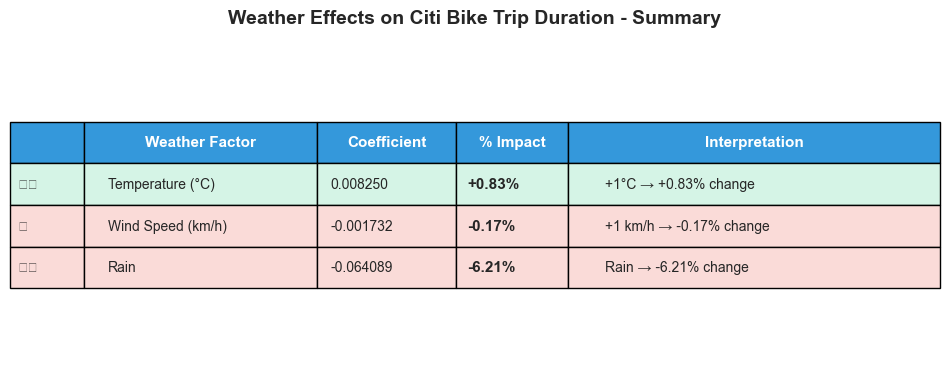

\n======================================================================
KEY FINDINGS:
🌡️  Warmer weather → Slightly LONGER trips (leisurely rides)
💨 Windier conditions → Marginally SHORTER trips (minimal effect)
🌧️  Rainy weather → Significantly SHORTER trips (quick commutes only)


In [100]:
# Visualization 3: Summary statistics table visualization
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

# Create summary data
summary_data = []
for idx, row in weather_coefs.iterrows():
    feature = row['Feature']
    coef = row['coef']
    pct = row['Percentage_Impact']
    
    if 'Temperature' in feature:
        interpretation = f"+1°C → {pct:+.2f}% change"
        icon = '🌡️'
    elif 'Wind' in feature:
        interpretation = f"+1 km/h → {pct:+.2f}% change"
        icon = '💨'
    else:  # Rain
        interpretation = f"Rain → {pct:+.2f}% change"
        icon = '🌧️'
    
    summary_data.append([icon, feature, f'{coef:.6f}', f'{pct:+.2f}%', interpretation])

# Create table
table = ax.table(cellText=summary_data,
                colLabels=['', 'Weather Factor', 'Coefficient', '% Impact', 'Interpretation'],
                cellLoc='left',
                loc='center',
                colWidths=[0.08, 0.25, 0.15, 0.12, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style the header
for i in range(5):
    cell = table[(0, i)]
    cell.set_facecolor('#3498db')
    cell.set_text_props(weight='bold', color='white', fontsize=11)

# Color code the rows
for i in range(1, 4):
    pct_value = float(summary_data[i-1][3].rstrip('%'))
    color = '#d5f4e6' if pct_value > 0 else '#fadbd8'
    
    for j in range(5):
        cell = table[(i, j)]
        cell.set_facecolor(color)
        if j == 3:  # % Impact column
            cell.set_text_props(weight='bold', fontsize=11)

plt.title('Weather Effects on Citi Bike Trip Duration - Summary', 
          fontsize=14, fontweight='bold', pad=20)
plt.show()

print("\\n" + "="*70)
print("KEY FINDINGS:")
print("="*70)
print("🌡️  Warmer weather → Slightly LONGER trips (leisurely rides)")
print("💨 Windier conditions → Marginally SHORTER trips (minimal effect)")
print("🌧️  Rainy weather → Significantly SHORTER trips (quick commutes only)")
print("="*70)